# Desafio 3 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from efficient_apriori import apriori
from IPython.display import display

## Configurações

In [2]:
seed = 42
data_path = Path("../desafio/assets/data/")

## Dados

### Obtenção dos dados

In [3]:
retail = pd.read_csv(data_path / "RetailBankEFG.csv", index_col="ID")
retail_cols = list(retail.columns)
print(retail_cols)

['Financiamento Casa', 'Financiamento Carro', 'Emprestimo _pessoal', 'Emprestimo _consignado', 'Emprestimo _limite_especial', 'Emprestimo _educacao', 'Emprestimo _viagem', 'Investimento CDB', 'Investimento Fundos']


In [4]:
investment = pd.read_csv(data_path / "InvestmentBankCDE.csv", index_col="ID")
investment_cols = list(investment.columns)
print(investment_cols)

['Investimento Fundos_cambiais', 'Investimento Fundos_commodities', 'Investimento LCI', 'Investimento LCA', 'Investimento Poupanca', 'Investimento Fundos Multimercado', 'Investimento Tesouro Direto']


In [5]:
insurance = pd.read_csv(data_path / "InsuranceCompanyABC.csv", index_col="ID")
insurance_cols = list(insurance.columns)
print(insurance_cols)

['Idade', 'Renda', 'Regiao', 'Genero', 'seguro auto', 'seguro vida Emp', 'seguro vida PF', 'Seguro Residencial']


In [6]:
answers = pd.read_csv(data_path / "ANSWERS.csv")
print(list(answers.columns))

['ID', 'Idade', 'Renda', 'Regiao', 'Genero', 'seguro auto', 'seguro vida Emp', 'seguro vida PF', 'Seguro Residencial', 'Investimento Fundos_cambiais', 'Investimento Fundos_commodities', 'Investimento LCI', 'Investimento LCA', 'Investimento Poupanca', 'Investimento Fundos Multimercado', 'Investimento Tesouro Direto', 'Financiamento Casa', 'Financiamento Carro', 'Emprestimo _pessoal', 'Emprestimo _consignado', 'Emprestimo _limite_especial', 'Emprestimo _educacao', 'Emprestimo _viagem', 'Investimento CDB', 'Investimento Fundos', 'RECOMMENDATION_1', 'CONFIDENCE_1', 'RECOMMENDATION_2', 'CONFIDENCE_2', 'RECOMMENDATION_3', 'CONFIDENCE_3']


In [7]:
assert insurance.index.equals(investment.index) and insurance.index.equals(retail.index)

df_all = pd.concat([insurance, investment, retail], axis=1).reset_index()
target_cols = [
    "RECOMMENDATION_1",
    "CONFIDENCE_1",
    "RECOMMENDATION_2",
    "CONFIDENCE_2",
    "RECOMMENDATION_3",
    "CONFIDENCE_3",
]

### Dados de exemplo

In [8]:
with pd.option_context("display.max_columns", None):
    display(df_all.sample(2, random_state=seed))

,ID,Idade,Renda,Regiao,Genero,seguro auto,seguro vida Emp,seguro vida PF,Seguro Residencial,Investimento Fundos_cambiais,Investimento Fundos_commodities,Investimento LCI,Investimento LCA,Investimento Poupanca,Investimento Fundos Multimercado,Investimento Tesouro Direto,Financiamento Casa,Financiamento Carro,Emprestimo _pessoal,Emprestimo _consignado,Emprestimo _limite_especial,Emprestimo _educacao,Emprestimo _viagem,Investimento CDB,Investimento Fundos
5032,79717.0,29.944,7511.742,CO,1.0,F,F,F,F,T,T,T,T,T,T,T,F,F,F,F,F,F,F,F,F
33,20858.0,36.170,5276.354,SE,0.0,T,F,F,F,T,T,F,T,F,F,F,T,T,F,F,F,T,F,F,F


### Tipos de dados

In [9]:
def fix_dtypes(df):
    df = df.copy()
    df["ID"] = df["ID"].astype(int)
    # Whether the client is of a given gender (which one?)
    df["Genero"] = df["Genero"].astype(bool)
    df["Regiao"] = df["Regiao"].astype("category")

    for col in df.columns:
        if df[col].iloc[0] in ["F", "T"] and df[col].nunique() == 2:
            df[col] = df[col].map({"T": True, "F": False})
    return df


df_all = fix_dtypes(df_all)

### Linhas duplicadas

Há várias linhas duplicadas no conjunto de dados:

In [10]:
df_all.duplicated().sum()

77

Podemos remover essas linhas:

In [11]:
df = df_all.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

### Informações gerais

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   ID                                10005 non-null  int64   
 1   Idade                             10005 non-null  float64 
 2   Renda                             10005 non-null  float64 
 3   Regiao                            10005 non-null  category
 4   Genero                            10005 non-null  bool    
 5   seguro auto                       10005 non-null  bool    
 6   seguro vida Emp                   10005 non-null  bool    
 7   seguro vida PF                    10005 non-null  bool    
 8   Seguro Residencial                10005 non-null  bool    
 9   Investimento Fundos_cambiais      10005 non-null  bool    
 10  Investimento Fundos_commodities   10005 non-null  bool    
 11  Investimento LCI                  10005 non-null  bool

Neste conjunto de dados:
- Há tanto variáveis numéricas quanto categóricas/booleanas
- Não há dados faltantes

### Variáveis categóricas e booleanas

In [13]:
non_numeric_cols = list(df.select_dtypes(include=["category", bool]).columns)
with pd.option_context("display.max_columns", None):
    display(df.describe(include=["category", bool]))

,Regiao,Genero,seguro auto,seguro vida Emp,seguro vida PF,Seguro Residencial,Investimento Fundos_cambiais,Investimento Fundos_commodities,Investimento LCI,Investimento LCA,Investimento Poupanca,Investimento Fundos Multimercado,Investimento Tesouro Direto,Financiamento Casa,Financiamento Carro,Emprestimo _pessoal,Emprestimo _consignado,Emprestimo _limite_especial,Emprestimo _educacao,Emprestimo _viagem,Investimento CDB,Investimento Fundos
count,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005,10005
unique,5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,SE,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
freq,4522,5495,7210,6553,7510,6679,6556,6550,6607,7020,5787,7474,7013,8879,7517,7965,8432,8405,8428,7539,5032,6649


In [14]:
df["ID"].astype("category").describe().to_frame()

,ID
count,10005
unique,9530
top,73519
freq,3


Observações:
- Somente para duas das variáveis booleanas o valor `True` é o mais frequente: `Genero` e `Investimento CDB`
- Alguns índices (`ID`) ainda ocorrem mais de uma vez

A título de exemplo, estes são dois dos clientes que têm mais de um registro (ordenados por idade, e mostrando apenas algumas colunas em que houve mudanças):

In [15]:
def get_sample(df):
    common_ids = df["ID"].value_counts().head(2).index
    sample_cols = [
        "ID",
        "Idade",
        "Renda",
        "Regiao",
        "Genero",
        "seguro auto",
        "Investimento LCI",
        "Emprestimo _viagem",
        "Investimento CDB",
        "Investimento Fundos",
    ]
    return df[df["ID"].isin(common_ids)].sort_values(["ID", "Idade"])[sample_cols]


with pd.option_context("display.max_columns", 10):
    display(get_sample(df))

,ID,Idade,Renda,Regiao,Genero,seguro auto,Investimento LCI,Emprestimo _viagem,Investimento CDB,Investimento Fundos
8193,5899,35.537,8236.453,CO,False,False,True,False,False,False
1619,5899,38.789,6700.487,S,False,False,True,False,False,False
9621,5899,46.515,8905.045,S,False,False,True,True,False,True
3393,87539,27.945,7173.152,SE,False,False,False,False,True,False
4750,87539,29.042,7459.294,NE,True,True,True,False,False,False
8136,87539,45.546,8217.991,SE,False,True,False,False,False,False


### Variáveis numéricas

In [16]:
numeric_cols = list(df.select_dtypes(include=float).columns)
with pd.option_context("display.max_columns", None):
    display(df.describe(include=float))

,Idade,Renda
count,10005.000000,10005.000000
mean,38.468291,7785.912913
std,12.209204,7330.738044
min,18.009000,2312.000000
25%,28.947000,6971.277000
50%,37.229000,7522.612000
75%,46.652000,8062.477000
max,85.605000,580000.000000


## Recomendação de produtos

### Produtos disponíveis

In [17]:
products = [
    "seguro auto",
    "seguro vida Emp",
    "seguro vida PF",
    "Seguro Residencial",
    "Investimento Fundos_cambiais",
    "Investimento Fundos_commodities",
    "Investimento LCI",
    "Investimento LCA",
    "Investimento Poupanca",
    "Investimento Fundos Multimercado",
    "Investimento Tesouro Direto",
    "Financiamento Casa",
    "Financiamento Carro",
    "Emprestimo _pessoal",
    "Emprestimo _consignado",
    "Emprestimo _limite_especial",
    "Emprestimo _educacao",
    "Emprestimo _viagem",
    "Investimento CDB",
    "Investimento Fundos",
]

### Transações

In [18]:
def get_transactions(df):
    get_transaction_products = lambda row: tuple(row[products].index[row[products]])
    return df.apply(get_transaction_products, axis=1).tolist()

In [19]:
transactions = get_transactions(df)

display(transactions[42:44])

[('Investimento LCA', 'Investimento Poupanca'),
 ('Investimento LCA', 'Emprestimo _pessoal', 'Investimento Fundos')]

### Geração de regras de associação com Apriori

In [20]:
def get_relevant_rules(transactions):
    itemsets, rules = apriori(
        transactions, min_support=0.1, min_confidence=0.8, max_length=5
    )
    return rules

In [21]:
rules = get_relevant_rules(transactions)

data = [
    {
        "antecedent": r.lhs,
        "consequent": r.rhs,
        "conf": r.confidence,
        "supp": r.support,
        "lift": r.lift,
        "conv": r.conviction,
    }
    for r in rules
]
df_rules = pd.DataFrame(data)
with pd.option_context("display.max_colwidth", None, "display.max_rows", 4):
    display(df_rules.sort_values("lift"))

,antecedent,consequent,conf,supp,lift,conv
16,"(Investimento Fundos, Investimento Fundos_commodities)","(Investimento CDB,)",0.819031,0.140230,1.628459,2.746610
17,"(Investimento Fundos, Investimento LCI)","(Investimento CDB,)",0.823850,0.136032,1.638040,2.821749
...,...,...,...,...,...,...
6,"(Emprestimo _consignado, Emprestimo _pessoal)","(Emprestimo _limite_especial,)",0.964077,0.115342,6.028493,23.385481
5,"(Emprestimo _limite_especial, Emprestimo _pessoal)","(Emprestimo _consignado,)",0.956882,0.115342,6.086209,19.545980


In [22]:
df_rules_long = (
    df_rules.set_index(["antecedent", "consequent"])
    .stack()
    .to_frame()
    .reset_index()
    .rename(columns={0: "value", "level_2": "metric"})
)

with pd.option_context("display.max_colwidth", None, "display.max_rows", 4):
    display(df_rules_long)

,antecedent,consequent,metric,value
0,"(Emprestimo _educacao,)","(Investimento CDB,)",conf,0.830691
1,"(Emprestimo _educacao,)","(Investimento CDB,)",supp,0.130935
...,...,...,...,...
626,"(Investimento Fundos_cambiais, Investimento Fundos_commodities, Investimento LCA)","(Investimento LCI, Investimento Poupanca)",lift,4.668453
627,"(Investimento Fundos_cambiais, Investimento Fundos_commodities, Investimento LCA)","(Investimento LCI, Investimento Poupanca)",conv,8.980341


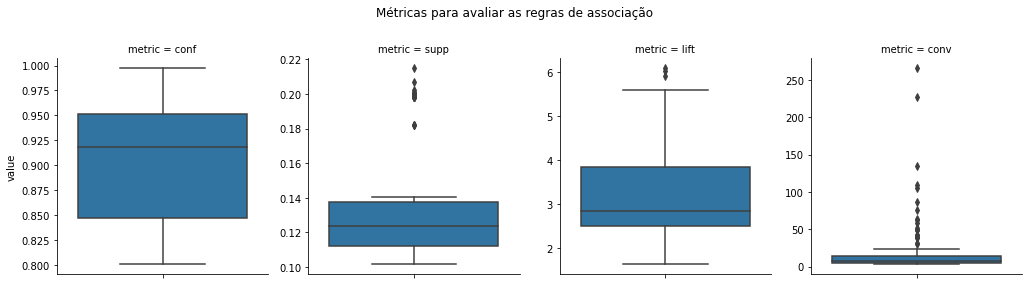

In [23]:
g = sns.catplot(
    y="value",
    col="metric",
    data=df_rules_long,
    kind="box",
    height=4,
    aspect=0.9,
    sharey=False,
)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Métricas para avaliar as regras de associação')
plt.show()

### Aplicação das regras

In [24]:
def apply_single_rule(df, rule):
    df = df.copy()
    relevant_rows = (df[list(rule.lhs)] == "T").all(axis=1)
    for idx in range(1, 1 + min(len(rule.rhs), 3)):
        cols = [f"RECOMMENDATION_{idx}", f"CONFIDENCE_{idx}"]
        df.loc[relevant_rows, cols] = (rule.rhs[idx - 1], rule.confidence)
    return df


def apply_rules(df, rules):
    for rule in rules:
        df = apply_single_rule(df, rule)
    return df

In [25]:
filled_answers = apply_rules(answers, rules)

print("Proporção de linhas para as quais cada recomendação foi preenchida:")
display((~filled_answers.isna()).mean().tail(6).rename("Proporção").to_frame())

Proporção de linhas para as quais cada recomendação foi preenchida:


,Proporção
RECOMMENDATION_1,0.649599
CONFIDENCE_1,0.649599
RECOMMENDATION_2,0.550765
CONFIDENCE_2,0.550765
RECOMMENDATION_3,0.124253
CONFIDENCE_3,0.124253


## Preenchimento do arquivo de respostas

In [26]:
filled_answers.to_csv("ANSWERS.csv", index=False)

In [27]:
!rm -rf código.zip
!zip -q código.zip notebook.ipynb
!ls código.zip

código.zip
